### Aluno: Lucas Rodrigues Aragão (538390)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def fitness_function(child, cost_matrix):
    """
    Avalia o custo total de uma solução (caminho) usando a matriz de custos.
    """
    custo_total = 0
    for i in range(len(child) - 1):
        custo_total += cost_matrix[child[i]][child[i + 1]]
    # Adiciona o custo de voltar à cidade inicial (fechar o circuito)
    custo_total += cost_matrix[child[-1]][child[0]]
    return custo_total

def gerar_pop_inicial(num_cidades, tam_pop):
    """
    Gera uma população inicial aleatória de caminhos.
    """
    return [np.random.permutation(num_cidades).tolist() for _ in range(tam_pop)]

def evaluate_fitness(population, cost_matrix):
    """
    Avalia o fitness de cada indivíduo na população.
    """
    results = []
    for individual in population:
        fitness = fitness_function(individual, cost_matrix)
        results.append((fitness, individual))
    return results

### Algoritmo Genético

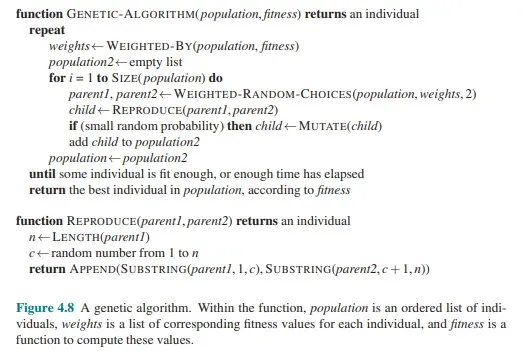   

In [ ]:
def weighted_random_choice(population, weights, n):
    """
    Seleciona `n` indivíduos da população com base nos pesos normalizados.
    """
    probabilities = [1 / w if w > 0 else 0 for w, _ in weights]
    probabilities /= np.sum(probabilities)
    chosen = np.random.choice(len(population), size=n, p=probabilities, replace=False)
    return [population[i][1] for i in chosen]  # Retorna os indivíduos



def reproduce(parent_1, parent_2):
    """
    Realiza o cruzamento de dois pais usando um ponto de corte.
    """
    n = len(parent_1)
    c = np.random.randint(1, n) 
    child = parent_1[:c]
    child.extend([gene for gene in parent_2 if gene not in child])
    return child


def mutate(child):
    """
    Faz mutações em uma solução trocando dois elementos.
    """
    a, b = np.random.choice(len(child), size=2, replace=False)
    child[a], child[b] = child[b], child[a]
    return child

In [3]:

def algoritmo_genetico(population, cost_matrix, taxa_mutacao, elitismo=2):
    """
    Executa uma geração do algoritmo genético, mantendo os melhores indivíduos via elitismo.
    """
    # Avaliar a população atual
    weights = evaluate_fitness(population, cost_matrix)
    weights.sort(key=lambda x: x[0])  # Ordenar pelo fitness (menor é melhor)
    
    # Selecionar os melhores indivíduos (elitismo)
    elite = [individual for _, individual in weights[:elitismo]]
    
    # Gerar nova população por reprodução e mutação
    new_population = []
    for _ in range(len(population) - elitismo):
        parent1, parent2 = weighted_random_choice(weights, weights, 2)
        child = reproduce(parent1, parent2)
        
        # Mutação com baixa probabilidade
        if np.random.rand() < taxa_mutacao:
            child = mutate(child)
        
        new_population.append(child)
    
    # Adicionar os indivíduos de elite à nova população
    new_population.extend(elite)
    
    # Avaliar a nova população para determinar o melhor indivíduo
    new_weights = evaluate_fitness(new_population, cost_matrix)
    best_child = min(new_weights, key=lambda x: x[0])[1]
    
    return new_population, best_child


def selecao_natural(matriz, num_geracoes, tam_pop, taxa_mutacao = 0.1 , elitismo = 5):
    """
    Executa o processo do algoritmo genético até convergência.
    """
    num_cidades = len(matriz)
    populacao = gerar_pop_inicial(num_cidades, tam_pop)
    i = 0
    dif = np.inf
    best = min(evaluate_fitness(populacao, matriz), key=lambda x: x[0])[0]
    bests = [best]

    while i < num_geracoes:
        populacao, best_child = algoritmo_genetico(populacao, matriz, taxa_mutacao, elitismo)
        new_best = fitness_function(best_child, matriz)
        dif = abs(best - new_best)
        best = new_best
        bests.append(best)
        print(f"A melhor solução da geração {i+1} custa {new_best}")
        i += 1
    
    return bests



### Colônia de Formigas

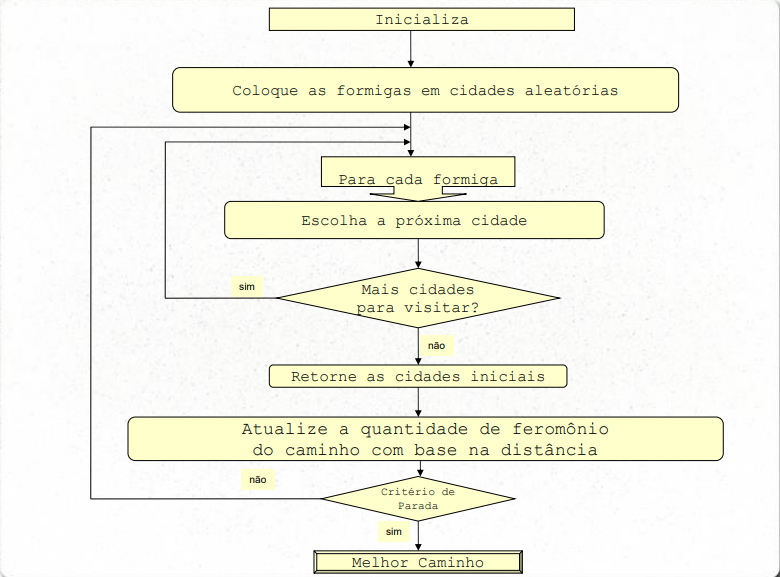

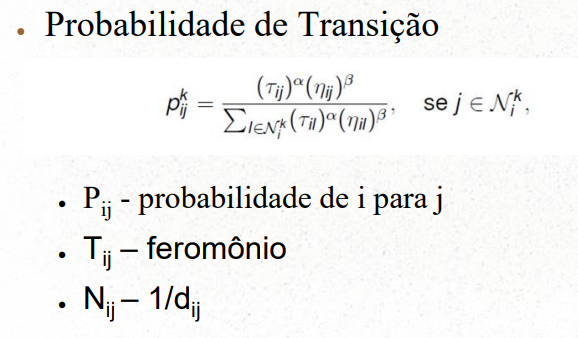

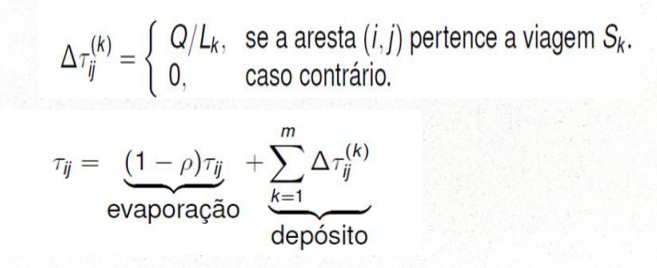

In [136]:
def ant_colony(cost_matrix, num_geracoes, coef_evaporacao = 0.1 ,alfa = 1 , beta = 1):
    # inicialmente deve inicializar a populacao de formigas com solucoes aleatorias
    matriz_fero = np.ones_like(cost_matrix).astype(float)
    tam_pop = len(cost_matrix)
    population = gerar_pop_inicial(num_cidades= tam_pop, tam_pop= tam_pop)
    #print(population)
    # calcular a quantidade de feromonios deixada em cada aresta (?)
    custo_caminhos = evaluate_fitness(population, cost_matrix)
    #print(custo_caminhos)
    matriz_fero = atualizar_fero(matriz_fero, population, custo_caminhos, coef_evaporacao)
    melhor_caminho = min(custo_caminhos, key=lambda x: x[0])[0]
    melhores_caminhos = [melhor_caminho]
    for i in range(num_geracoes):
       # calcular as novas probabilidades de transicao  
        print(f"O melhor caminho na geracao {i} custa {melhor_caminho}")

        prob_trans = atualizar_prob_transicao(cost_matrix, matriz_fero, alfa, beta)     
       # gerar a nova populacao baseada nas novas probabilidades de transicao 
        new_population = gerar_nova_populacao(num_cidades= tam_pop, prob_trans= prob_trans) 

        population = new_population
        custo_caminhos = evaluate_fitness(population, cost_matrix)
        melhor_caminho = min(custo_caminhos, key=lambda x: x[0])[0]

        melhores_caminhos.append(melhor_caminho)
        # atualizar a matriz de feromonios 
        matriz_fero = atualizar_fero(matriz_fero, population, custo_caminhos, coef_evaporacao)
    return melhores_caminhos

def atualizar_fero(matriz_fero, pop_atual, custo_caminhos, coef_evaporacao):      
    # meio que precisa ter um tracking de quant foi depositado em cada aresta para poder usar o coeficiente de evaporacao corretamente depois 
    matriz_depositos = np.zeros_like(matriz_fero).astype(float)
    for index_1,formiga in enumerate(pop_atual):

        for index_2 in range(len(formiga) - 1):
            v1 = formiga[index_2]
            v2 = formiga[index_2+1]
            custo_caminho = custo_caminhos[index_1][0]
            matriz_depositos[v1][v2] += 1/custo_caminho
           # print(f"O custo do caminho eh {custo_caminho}")
    # depois de calcular todos os depositos deixados 
    #print("matriz_depositos depositos ficou assim")
    #print(matriz_depositos)
    num_cidades = len(matriz_fero)
    for v1 in range(num_cidades):
        for v2 in range(num_cidades):
            matriz_fero[v1][v2] = ((matriz_fero[v1][v2]) * (1 - coef_evaporacao)) + matriz_depositos[v1][v2]
            #print(f"matriz de feromonios na pos {v1} {v2} eh igual a {matriz_fero[v1][v2]}")
    return matriz_fero

def atualizar_prob_transicao(cost_matrix, matriz_fero, alfa, beta):
    # calcular a prob de transicao de um no para outro 
    
    num_cidades = len(cost_matrix)
    matriz_probs = np.zeros_like(matriz_fero)

    for v1 in range(num_cidades):
        total_transicao = 0
        for v2 in range(num_cidades):
            if v1 != v2:
                trans_v1_v2 = ((matriz_fero[v1][v2]) ** alfa) * ((cost_matrix[v1][v2]) ** beta)
                matriz_probs[v1][v2] = trans_v1_v2
                total_transicao += trans_v1_v2
        
        matriz_probs[v1] = matriz_probs[v1] / total_transicao
    #print(matriz_probs)
    return matriz_probs

def gerar_nova_populacao(num_cidades, prob_trans):
    new_pop = []
    for formiga in range(num_cidades):
        # Cada formiga começa em uma cidade única
        cidade_atual = formiga  
        solucao = [cidade_atual]
        
        while len(solucao) < num_cidades:
            prob = prob_trans[cidade_atual]
            # Evitar cidades já visitadas
            prob = np.array([p if i not in solucao else 0 for i, p in enumerate(prob)])  
            prob /= prob.sum()  
            prox_cidade = np.random.choice(range(num_cidades), p=prob)
            solucao.append(prox_cidade)
            cidade_atual = prox_cidade

        new_pop.append(solucao)
    return new_pop
    

## Execuções

In [47]:
cost_matrix = [
    [0, 10, 15, 45, 5, 45, 50, 44, 30, 100, 67, 33, 90, 17, 50],
    [15, 0, 100, 30, 20, 25, 80, 45, 41, 5, 45, 10, 90, 10, 35],
    [40, 80, 0, 90, 70, 33, 100, 70, 30, 23, 80, 60, 47, 33, 25],
    [100, 8, 5, 0, 5, 40, 21, 20, 35, 14, 55, 35, 21, 5, 40],
    [17, 10, 33, 45, 0, 14, 50, 27, 33, 60, 17, 10, 20, 13, 71],
    [15, 70, 90, 20, 11, 0, 15, 35, 30, 15, 18, 35, 15, 90, 23],
    [25, 19, 18, 30, 100, 55, 0, 70, 55, 41, 55, 100, 18, 14, 18],
    [40, 15, 60, 45, 70, 33, 25, 0, 27, 60, 80, 35, 30, 41, 35],
    [21, 34, 17, 10, 11, 40, 8, 32, 0, 47, 76, 40, 21, 90, 21],
    [35, 100, 5, 18, 43, 25, 14, 30, 39, 0, 17, 35, 15, 13, 40],
    [38, 20, 23, 30, 5, 55, 50, 33, 70, 14, 0, 60, 30, 35, 21],
    [15, 14, 45, 21, 100, 10, 8, 20, 35, 43, 8, 0, 15, 100, 23],
    [80, 10, 5, 20, 35, 8, 90, 5, 44, 10, 80, 14, 0, 25, 80],
    [33, 90, 40, 18, 70, 45, 25, 23, 90, 44, 43, 70, 5, 0, 25],
    [25, 70, 45, 50, 5, 45, 20, 100, 25, 50, 35, 10, 90, 5, 0]
]

### Alg genético

A melhor solução da geração 1 custa 347
A melhor solução da geração 2 custa 332
A melhor solução da geração 3 custa 332
A melhor solução da geração 4 custa 321
A melhor solução da geração 5 custa 311
A melhor solução da geração 6 custa 311
A melhor solução da geração 7 custa 311
A melhor solução da geração 8 custa 290
A melhor solução da geração 9 custa 290
A melhor solução da geração 10 custa 290
A melhor solução da geração 11 custa 277
A melhor solução da geração 12 custa 252
A melhor solução da geração 13 custa 252
A melhor solução da geração 14 custa 252
A melhor solução da geração 15 custa 252
A melhor solução da geração 16 custa 251
A melhor solução da geração 17 custa 251
A melhor solução da geração 18 custa 251
A melhor solução da geração 19 custa 251
A melhor solução da geração 20 custa 251
A melhor solução da geração 21 custa 251
A melhor solução da geração 22 custa 240
A melhor solução da geração 23 custa 240
A melhor solução da geração 24 custa 240
A melhor solução da geraç

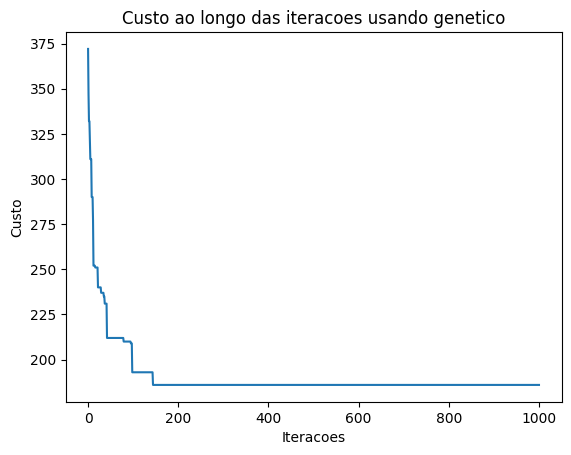

In [6]:
bests = selecao_natural(matriz= cost_matrix, num_geracoes= 1000, tam_pop= 100, taxa_mutacao= 0.3)


plt.plot(bests)
plt.title("Custo ao longo das iteracoes usando genetico")
plt.xlabel("Iteracoes")
plt.ylabel("Custo")
plt.show()

### Colônia de Formigas

In [147]:
melhores = ant_colony(cost_matrix= cost_matrix, num_geracoes= 30, coef_evaporacao= 0.05, alfa= 2, beta= 1 )

O melhor caminho na geracao 0 custa 417
O melhor caminho na geracao 1 custa 634
O melhor caminho na geracao 2 custa 637
O melhor caminho na geracao 3 custa 604
O melhor caminho na geracao 4 custa 675
O melhor caminho na geracao 5 custa 531
O melhor caminho na geracao 6 custa 628
O melhor caminho na geracao 7 custa 565
O melhor caminho na geracao 8 custa 587
O melhor caminho na geracao 9 custa 562
O melhor caminho na geracao 10 custa 639
O melhor caminho na geracao 11 custa 534
O melhor caminho na geracao 12 custa 556
O melhor caminho na geracao 13 custa 591
O melhor caminho na geracao 14 custa 597
O melhor caminho na geracao 15 custa 658
O melhor caminho na geracao 16 custa 645
O melhor caminho na geracao 17 custa 538
O melhor caminho na geracao 18 custa 699
O melhor caminho na geracao 19 custa 589
O melhor caminho na geracao 20 custa 681
O melhor caminho na geracao 21 custa 750
O melhor caminho na geracao 22 custa 598
O melhor caminho na geracao 23 custa 570
O melhor caminho na geraca

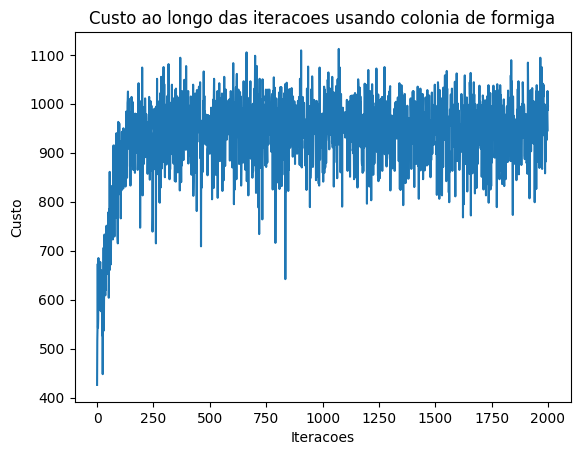

In [119]:
plt.plot(melhores)
plt.title("Custo ao longo das iteracoes usando colonia de formiga")
plt.xlabel("Iteracoes")
plt.ylabel("Custo")
plt.show()